In [84]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.cluster import KMeans, spectral_clustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from copy import deepcopy


In [52]:
os.chdir("/home/g.esposito/sc2-benchmark")
path = os.getcwd()

log_folders = os.listdir("FSIM_W_local_obj_v2")

general_report = pd.DataFrame([])
for cnf in log_folders:
    file_path = os.path.join(path,"FSIM_W_local_obj_v2",  cnf)
    #print(file_path)
    if os.path.isdir(file_path):
        report_path = os.path.join(file_path, "fsim_full_report.csv")
        report = pd.read_csv(report_path)
        report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"
        # print(report.columns)
        report['bit_faulty_position'] = np.log2(report['bitmask'])
        report.drop(columns=['kernel.1','channel.1','row.1','col.1','BitMask', 'Unnamed: 0'], inplace=True)
        tot_boxes_per_fault = report['boxes_Crit'] + report['boxes_SDC'] + report['boxes_Masked']
        report['Crit_perc'] = (report['boxes_Crit'] / tot_boxes_per_fault)*100
        report['SDC_perc'] = (report['boxes_SDC'] / tot_boxes_per_fault)*100
        report['masked_perc'] = (report['boxes_Masked'] / tot_boxes_per_fault)*100
        report['Crit_perc'].fillna(0, inplace=True)
        report['SDC_perc'].fillna(0, inplace=True)
        report['masked_perc'].fillna(0, inplace=True)
        general_report = pd.concat([general_report, report], axis=0, ignore_index=True)

# general_report.head()

In [53]:
general_report.iloc[:,9:].describe()

,boxes_Masked,fault_iou@1,Class,area_ratio,average_golden_boxes,average_faulty_boxes,average_target_boxes,Layer,Ffree_Weight,Faulty_weight,Abs_error,bit_faulty_position,Crit_perc,SDC_perc,masked_perc
count,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.00,1883.0,1.883000e+03,1.883000e+03,1.881000e+03,1883.000000,1883.000000,1883.000000,1883.000000
mean,2.361126,86.396876,1.557090,88.202823,5.755714,6.155119,7.78,0.0,2.079586e+09,2.108679e+09,3.587986e+35,25.576208,0.433490,90.192931,0.398539
std,12.187833,27.427582,0.653045,28.583713,0.480004,2.022299,0.00,0.0,1.073209e+09,1.137351e+09,2.649114e+37,3.428472,3.544663,28.613005,1.990108
min,0.000000,0.000000,0.000000,0.000000,5.060000,0.000000,7.78,0.0,9.602627e+08,4.698007e+08,-2.975173e+38,20.000000,0.000000,0.000000,0.000000
25%,0.000000,93.651417,1.000000,95.061097,5.060000,5.970000,7.78,0.0,1.041989e+09,1.025763e+09,-1.340301e-01,23.000000,0.000000,99.202870,0.000000
50%,0.000000,94.682541,2.000000,96.757324,5.800000,6.850000,7.78,0.0,1.060400e+09,2.124033e+09,3.906250e-03,26.000000,0.173010,99.604743,0.000000
75%,1.000000,96.285149,2.000000,97.839247,6.290000,7.290000,7.78,0.0,3.188853e+09,3.176638e+09,1.622108e-01,29.000000,0.478469,99.826389,0.172414
max,190.000000,97.906418,2.000000,332.220180,6.300000,7.500000,7.78,0.0,3.222126e+09,4.294543e+09,2.399797e+38,31.000000,100.000000,100.000000,30.351438


## Distribution Analysis
- layer
- kernel
- channel
- row
- col
- BitMask
- gold_iou: Intersection over Union score of the golden model for each num_layers compression
- boxes_Crit: most of the faults does not produce any critical fault and the faults that produce more than 10 critical boxes are only 7
- boxes_SDC: for each fault the number of SDC boxes are almost the same (around 517) which is very high that means that often the faults affect the model producing a slightly different result with respect to the golden model. 
- boxes_Masked: only in few cases the boxes predicted by the faulty model has perfectly masked boxes. Actually looking at the mean, we can see that all the faults, on average, 2 or 3 masked boxes (not that much) (remember that each fault is tested over 100 images).
- fault_iou@1: all the predicted boxes have iou score of 87% with respect to the boxes predicted by the golden model
- area_ratio: the same holds for the ratio between the ratio between the golden and faulty model (the number shows that the faulty tends to underestimate the area of the predicted boxes of, on average 12%)
- average_golden_boxes: The average number of bounding boxes over all the images of the dataset is 5.06
- average_faulty_boxes: The average number of bounding boxes over all the images of the dataset is 5.44 which is similar to the one of the golden model
- average_target_boxes: the expected number of boxes for each image is 7.78
- Ffree_Weight
- Faulty_weight
- Abs_error
- conf_detail: label of the configuration (let us try to use it for the clustering)

In [54]:
general_report[general_report['boxes_Crit'] > 10]

,layer,kernel,channel,row,col,bitmask,gold_iou@1,boxes_Crit,boxes_SDC,boxes_Masked,...,average_target_boxes,Layer,Ffree_Weight,Faulty_weight,Abs_error,conf_detail,bit_faulty_position,Crit_perc,SDC_perc,masked_perc
323,0,27,1,2,4,67108864,69.914322,48,11,0,...,7.78,0.0,3.221391e+09,3.288500e+09,520.089036,cnf12,26.0,81.355932,18.644068,0.0
438,0,16,2,3,3,2147483648,69.914322,13,609,0,...,7.78,0.0,3.204665e+09,1.057182e+09,-1.025879,cnf12,31.0,2.090032,97.909968,0.0
909,0,56,1,2,5,33554432,69.967499,33,575,0,...,7.78,0.0,3.187601e+09,3.221156e+09,1.867199,cnf9,25.0,5.427632,94.572368,0.0
987,0,0,2,6,6,33554432,69.967499,43,562,0,...,7.78,0.0,3.184860e+09,3.218414e+09,1.560820,cnf9,25.0,7.107438,92.892562,0.0
1034,0,39,2,0,1,33554432,69.967499,11,612,0,...,7.78,0.0,3.185377e+09,3.218931e+09,1.618584,cnf9,25.0,1.765650,98.234350,0.0
1038,0,14,1,2,5,134217728,69.967499,11,614,0,...,7.78,0.0,1.056065e+09,9.218471e+08,0.473176,cnf9,27.0,1.760000,98.240000,0.0
1391,0,4,1,1,2,33554432,70.289207,12,566,0,...,7.78,0.0,1.028573e+09,1.062128e+09,-0.757273,cnf2,25.0,2.076125,97.923875,0.0


In [55]:
general_report['conf_detail'].unique()

array(['cnf1', 'cnf12', 'cnf6', 'cnf9', 'teacher_cnf', 'cnf2', 'cnf3'],
      dtype=object)

In [56]:
print(general_report['bitmask'].unique())
np.log2(general_report['bitmask'].unique())

[1073741824    2097152   67108864   16777216    4194304  134217728
   33554432  268435456    1048576  536870912 2147483648    8388608]


array([30., 21., 26., 24., 22., 27., 25., 28., 20., 29., 31., 23.])

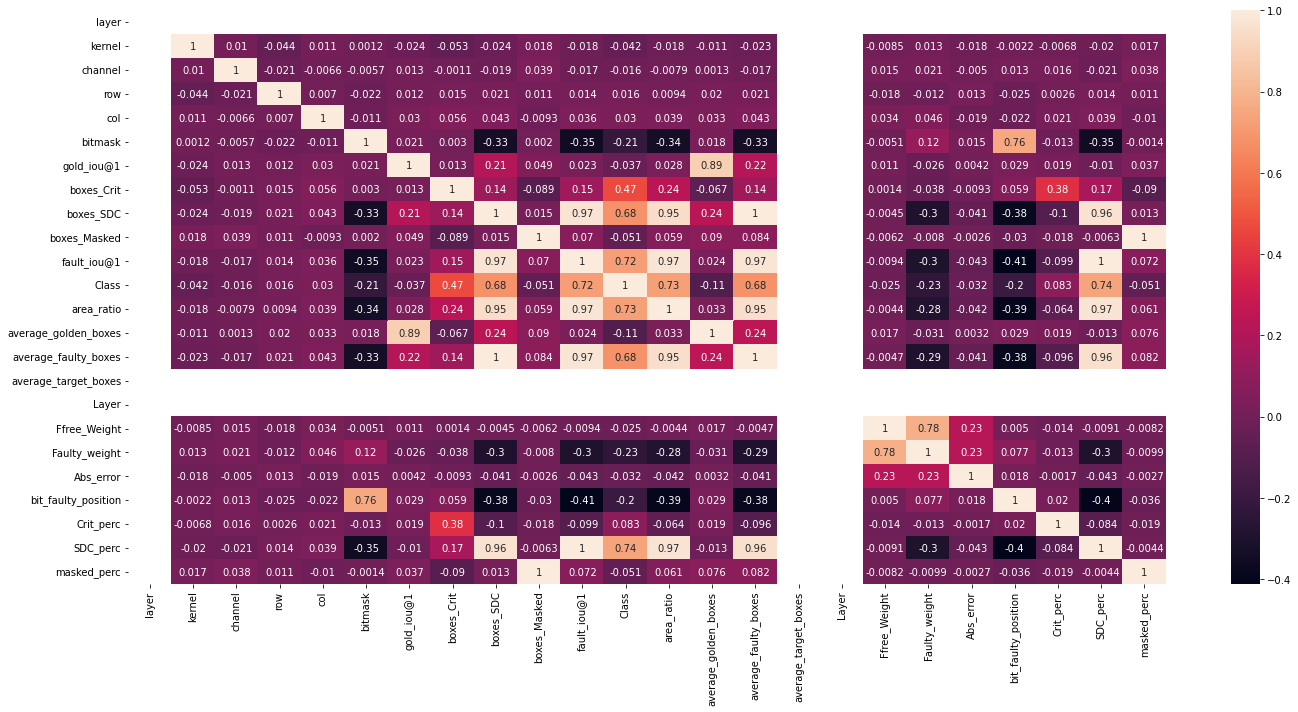

In [57]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.heatmap(general_report.corr(),ax=ax, annot=True)
# sns.heatmap(general_report.corr(method='spearman'),ax=ax[1], annot=True)
plt.tight_layout()

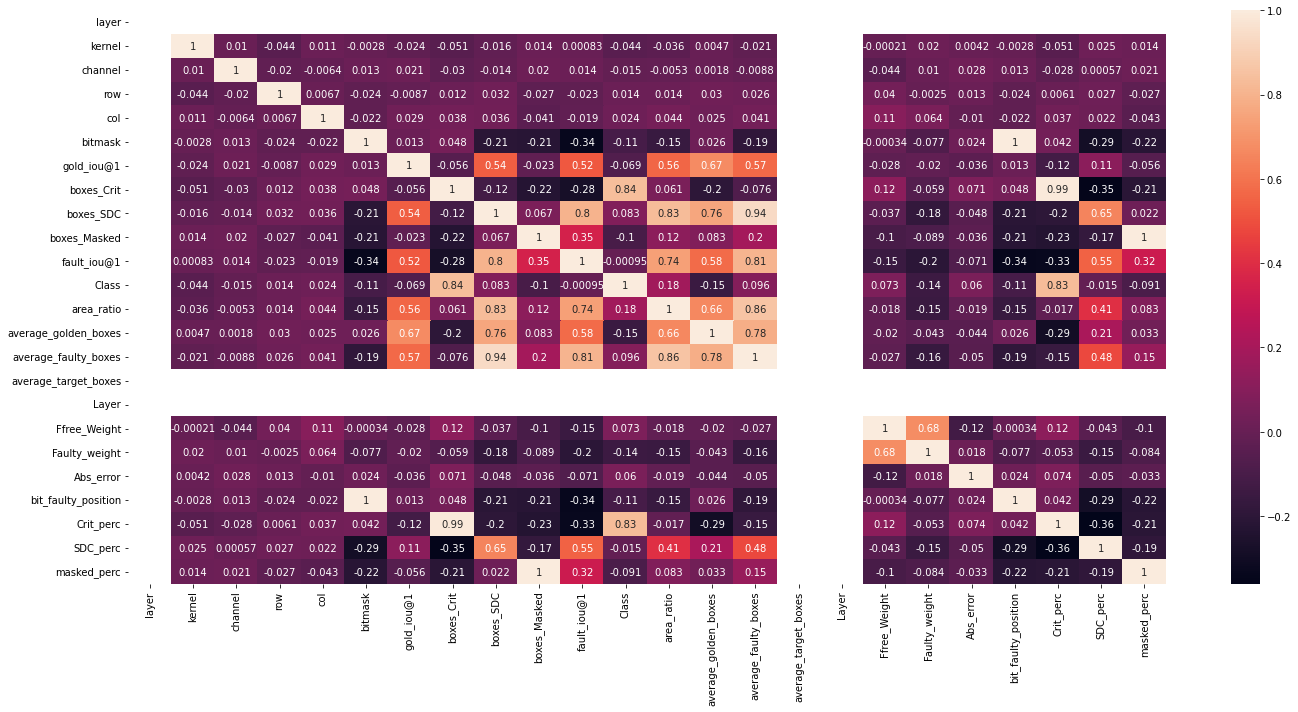

In [58]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
# sns.heatmap(general_report.corr(),ax=ax, annot=True)
sns.heatmap(general_report.corr(method='spearman'),ax=ax, annot=True)
plt.tight_layout()

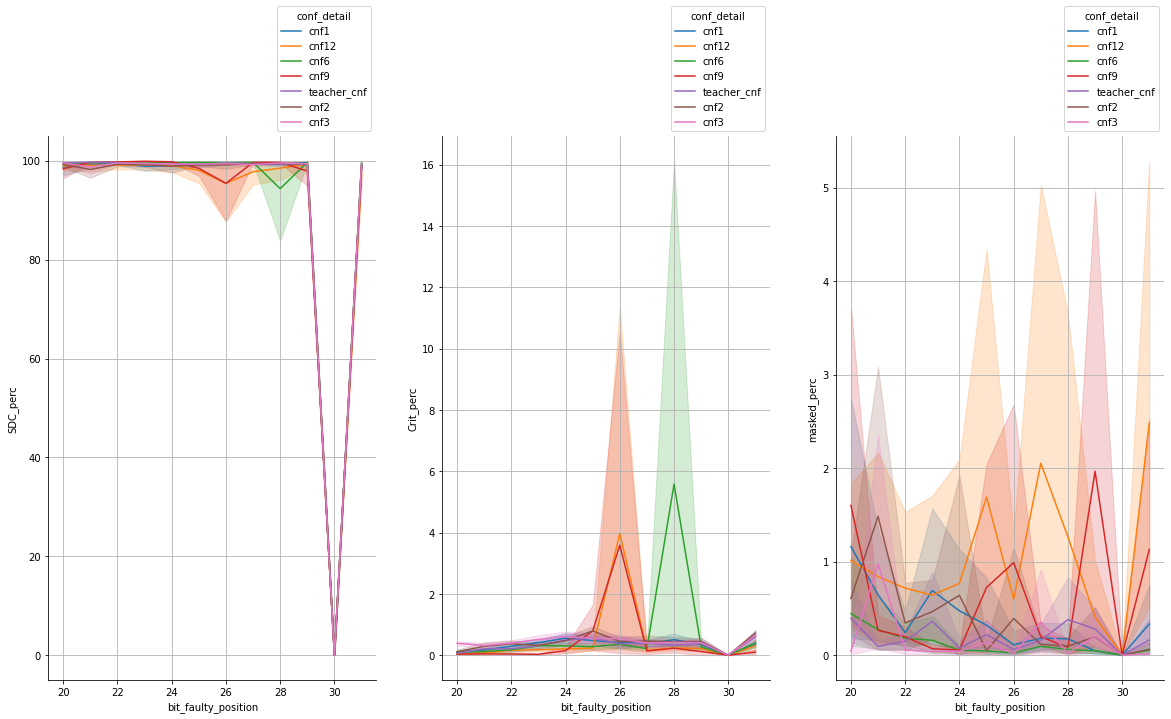

In [59]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
sns.despine(fig)
sns.lineplot(data=general_report, x='bit_faulty_position', y='SDC_perc', ax=ax[0], hue ='conf_detail')
sns.move_legend(ax[0], "lower right", bbox_to_anchor=(1, 1))
ax[0].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='Crit_perc', ax=ax[1],hue ='conf_detail')
sns.move_legend(ax[1], "lower right", bbox_to_anchor=(1, 1))
ax[1].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='masked_perc', ax=ax[2], hue ='conf_detail')
sns.move_legend(ax[2], "lower right", bbox_to_anchor=(1, 1))
ax[2].grid()


In [60]:
general_report['SDC_perc'].isna().sum()

0


## Results:
- how the SDC should be interpreted? because the reasons why records are labeled as SDC are different. 

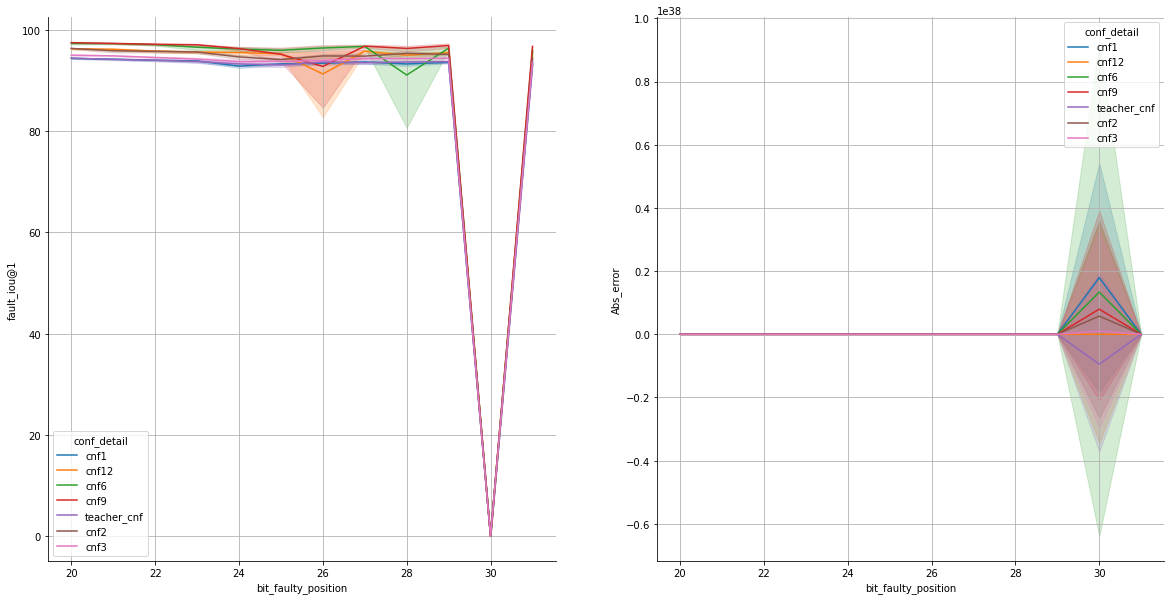

In [61]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
sns.despine(fig)
sns.lineplot(data=general_report, x='bit_faulty_position', y='fault_iou@1', ax=ax[0], hue ='conf_detail')
ax[0].grid()
sns.lineplot(data=general_report, x='bit_faulty_position', y='Abs_error', ax=ax[1], hue ='conf_detail')
ax[1].grid()

In [62]:
general_report[general_report['bitmask'] == 1073741824]

,layer,kernel,channel,row,col,bitmask,gold_iou@1,boxes_Crit,boxes_SDC,boxes_Masked,...,average_target_boxes,Layer,Ffree_Weight,Faulty_weight,Abs_error,conf_detail,bit_faulty_position,Crit_perc,SDC_perc,masked_perc
0,0,55,2,0,0,1073741824,68.310318,0,0,0,...,7.78,0.0,1.068061e+09,2.141802e+09,NaN,cnf1,30.0,0.0,0.0,0.0
5,0,24,1,1,5,1073741824,68.310318,0,0,0,...,7.78,0.0,1.044284e+09,2.118026e+09,-6.330728e+37,cnf1,30.0,0.0,0.0,0.0
10,0,1,1,4,6,1073741824,68.310318,0,0,0,...,7.78,0.0,3.185404e+09,4.259145e+09,3.678654e+37,cnf1,30.0,0.0,0.0,0.0
12,0,30,0,4,1,1073741824,68.310318,0,0,0,...,7.78,0.0,3.203844e+09,4.277586e+09,1.640180e+38,cnf1,30.0,0.0,0.0,0.0
16,0,26,0,2,6,1073741824,68.310318,0,0,0,...,7.78,0.0,1.042233e+09,2.115974e+09,-5.290574e+37,cnf1,30.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1817,0,7,2,2,1,1073741824,69.619514,0,0,0,...,7.78,0.0,3.167231e+09,4.240973e+09,8.312324e+36,cnf3,30.0,0.0,0.0,0.0
1836,0,49,0,3,6,1073741824,69.619514,0,0,0,...,7.78,0.0,1.044534e+09,2.118276e+09,-6.457571e+37,cnf3,30.0,0.0,0.0,0.0
1845,0,47,1,0,2,1073741824,69.619514,0,0,0,...,7.78,0.0,3.205171e+09,4.278913e+09,1.848035e+38,cnf3,30.0,0.0,0.0,0.0
1853,0,12,2,4,3,1073741824,69.619514,0,0,0,...,7.78,0.0,1.018659e+09,2.092401e+09,-7.622513e+36,cnf3,30.0,0.0,0.0,0.0


In [63]:
to_melt = general_report[['conf_detail','boxes_SDC', 'boxes_Masked', 'boxes_Crit']]
df_melted = to_melt.melt(id_vars='conf_detail', var_name='box_type', value_name='box_count')

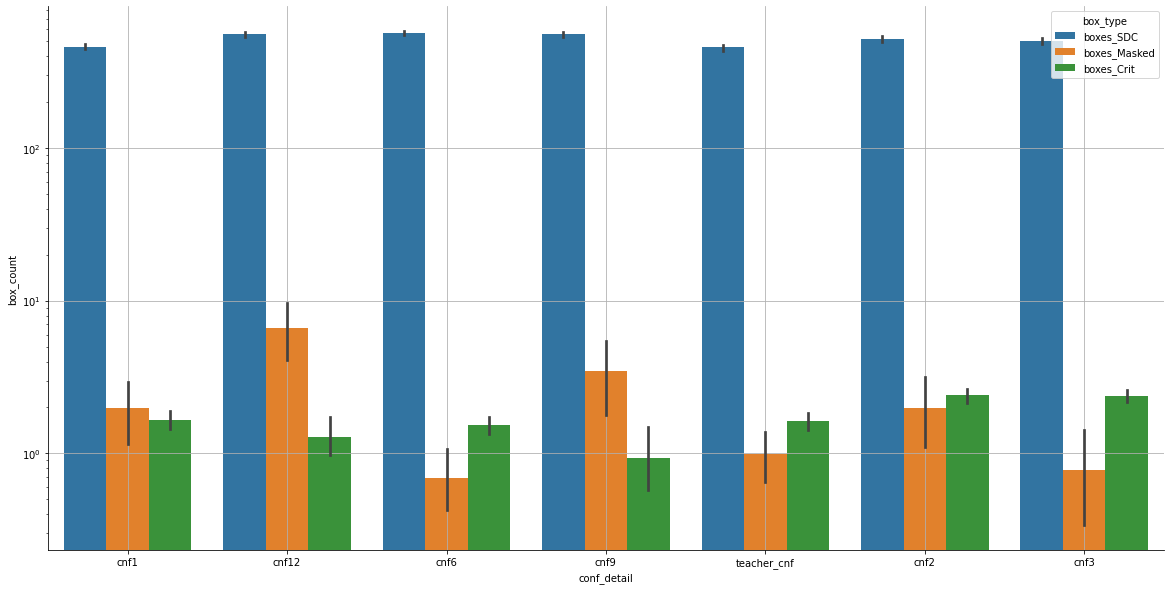

In [64]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.despine(fig)
sns.barplot(x='conf_detail', y='box_count', hue='box_type', data=df_melted, ax=ax)
ax.grid()
ax.set_yscale('log')


## Clustering

In [65]:
general_report

,layer,kernel,channel,row,col,bitmask,gold_iou@1,boxes_Crit,boxes_SDC,boxes_Masked,...,average_target_boxes,Layer,Ffree_Weight,Faulty_weight,Abs_error,conf_detail,bit_faulty_position,Crit_perc,SDC_perc,masked_perc
0,0,55,2,0,0,1073741824,68.310318,0,0,0,...,7.78,0.0,1.068061e+09,2.141802e+09,NaN,cnf1,30.0,0.000000,0.000000,0.000000
1,0,7,1,5,6,2097152,68.310318,1,505,0,...,7.78,0.0,3.205382e+09,3.207479e+09,0.125000,cnf1,21.0,0.197628,99.802372,0.000000
2,0,0,1,5,0,67108864,68.310318,2,504,0,...,7.78,0.0,1.042953e+09,9.758441e+08,0.165561,cnf1,26.0,0.395257,99.604743,0.000000
3,0,30,0,0,2,16777216,68.310318,5,499,1,...,7.78,0.0,3.197474e+09,3.214252e+09,0.876488,cnf1,24.0,0.990099,98.811881,0.198020
4,0,58,0,4,1,4194304,68.310318,0,504,2,...,7.78,0.0,3.193468e+09,3.189274e+09,-0.062500,cnf1,22.0,0.000000,99.604743,0.395257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878,0,48,0,4,3,2147483648,69.619514,4,572,0,...,7.78,0.0,3.199081e+09,1.051597e+09,-0.680080,cnf3,31.0,0.694444,99.305556,0.000000
1879,0,38,2,6,1,1048576,69.619514,4,573,0,...,7.78,0.0,3.195604e+09,3.194555e+09,-0.015625,cnf3,20.0,0.693241,99.306759,0.000000
1880,0,43,2,1,4,134217728,69.619514,1,575,0,...,7.78,0.0,3.188815e+09,3.054598e+09,-0.142049,cnf3,27.0,0.173611,99.826389,0.000000
1881,0,39,1,6,1,536870912,69.619514,5,571,0,...,7.78,0.0,3.181916e+09,2.645045e+09,-0.082118,cnf3,29.0,0.868056,99.131944,0.000000


In [66]:
general_report.columns

Index(['layer', 'kernel', 'channel', 'row', 'col', 'bitmask', 'gold_iou@1',
       'boxes_Crit', 'boxes_SDC', 'boxes_Masked', 'fault_iou@1', 'Class',
       'area_ratio', 'average_golden_boxes', 'average_faulty_boxes',
       'average_target_boxes', 'Layer', 'Ffree_Weight', 'Faulty_weight',
       'Abs_error', 'conf_detail', 'bit_faulty_position', 'Crit_perc',
       'SDC_perc', 'masked_perc'],
      dtype='object')

In [85]:
clustering_df = general_report[['conf_detail', 'fault_iou@1', 'bit_faulty_position', 'area_ratio']]

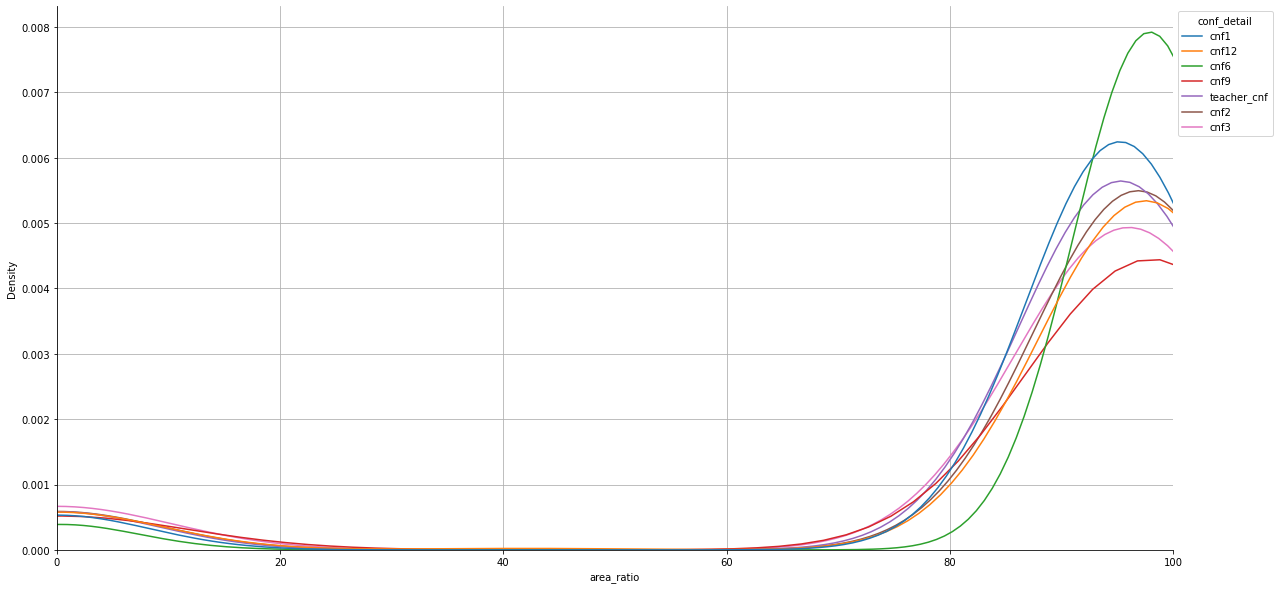

In [120]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.despine(fig)
sns.kdeplot(x = 'area_ratio', data=clustering_df, hue = 'conf_detail')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(0, 100)
ax.grid()

(0.0, 100.0)

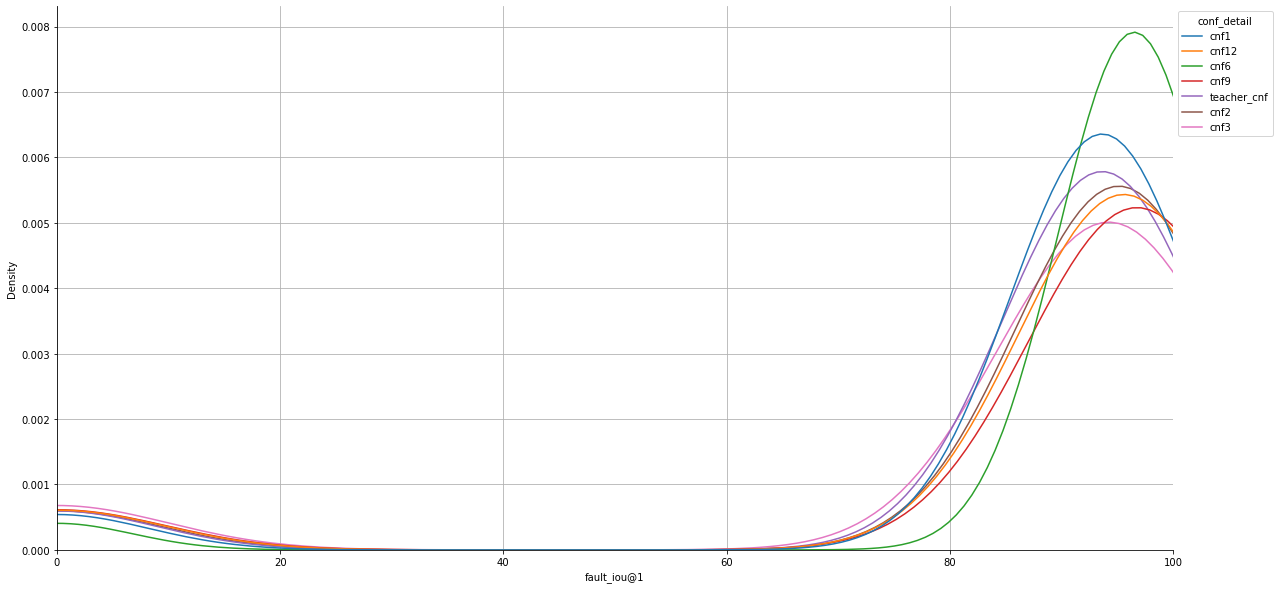

In [121]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.despine(fig)
sns.kdeplot(x = 'fault_iou@1', data=clustering_df, hue = 'conf_detail')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.grid()
ax.set_xlim(0, 100)

In [28]:
kmeans = KMeans(
    init="random",
    n_init=10,
    max_iter=300,
    random_state=42
)

In [111]:

scaled_clustering_df = deepcopy(clustering_df)
scaler = MinMaxScaler(feature_range = (0,1))
scaled_clustering_df[['fault_iou@1', 'bit_faulty_position', 'area_ratio']] = scaler.fit_transform(clustering_df[['fault_iou@1', 'bit_faulty_position', 'area_ratio']])
valuable_clustering_df = scaled_clustering_df[scaled_clustering_df['fault_iou@1'] != 0]

print(valuable_clustering_df.describe())

       fault_iou@1  bit_faulty_position   area_ratio
count  1714.000000          1714.000000  1714.000000
mean      0.969452             0.467275     0.291673
std       0.042677             0.298661     0.022207
min       0.000010             0.000000     0.022624
25%       0.959873             0.181818     0.287662
50%       0.969366             0.454545     0.291700
75%       0.984764             0.727273     0.294623
max       1.000000             1.000000     1.000000


In [75]:
valuable_clustering_df = clustering_df[clustering_df['fault_iou@1'] > 0]
valuable_clustering_df[clustering_df['fault_iou@1'] < 50]

<ipython-input-75-ccf67d84eeda>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valuable_clustering_df[clustering_df['fault_iou@1'] < 50]


,conf_detail,fault_iou@1,bit_faulty_position,area_ratio
323,cnf12,5.718829,26.0,41.888897
586,cnf6,0.000959,28.0,7.516190
1049,cnf9,1.254249,26.0,13.078729


/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


For n_clusters = 2 The average silhouette_score is : 0.7205806477529246


/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


For n_clusters = 3 The average silhouette_score is : 0.641254559686027


/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


For n_clusters = 4 The average silhouette_score is : 0.6212984616959506


/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


For n_clusters = 5 The average silhouette_score is : 0.6205216304381861


/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home/g.esposito/miniconda3/envs/sc2-benchmark/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6 The average silhouette_score is : 0.6276408701619774


No handles with labels found to put in legend.
No handles with labels found to put in legend.


For n_clusters = 7 The average silhouette_score is : 0.6752088728583436


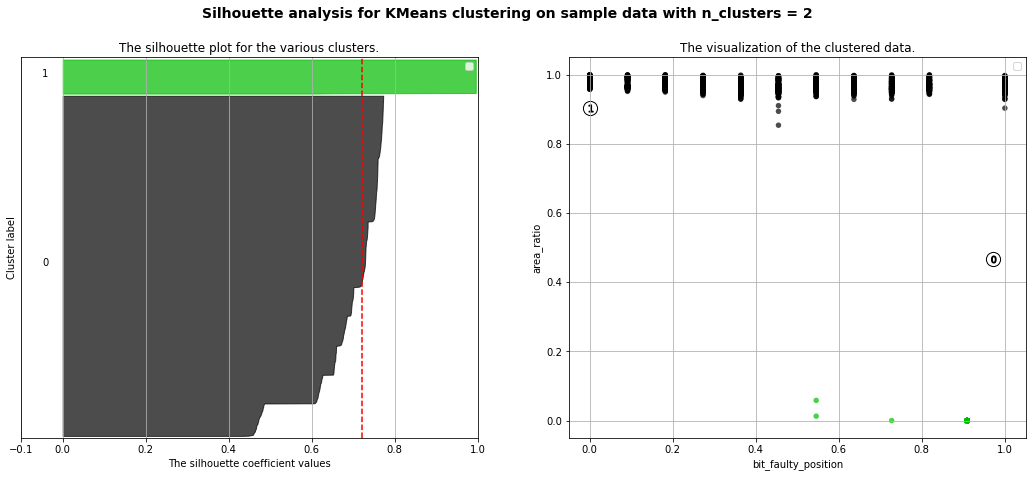

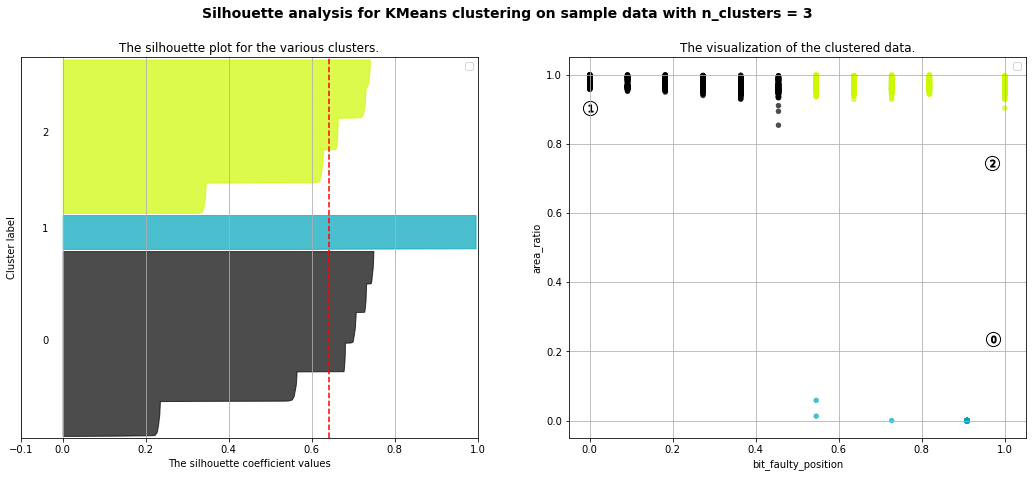

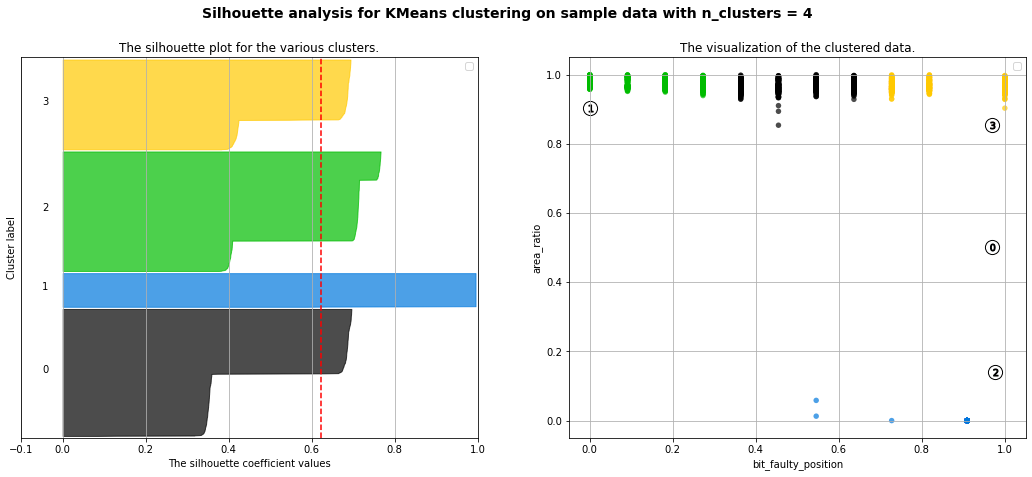

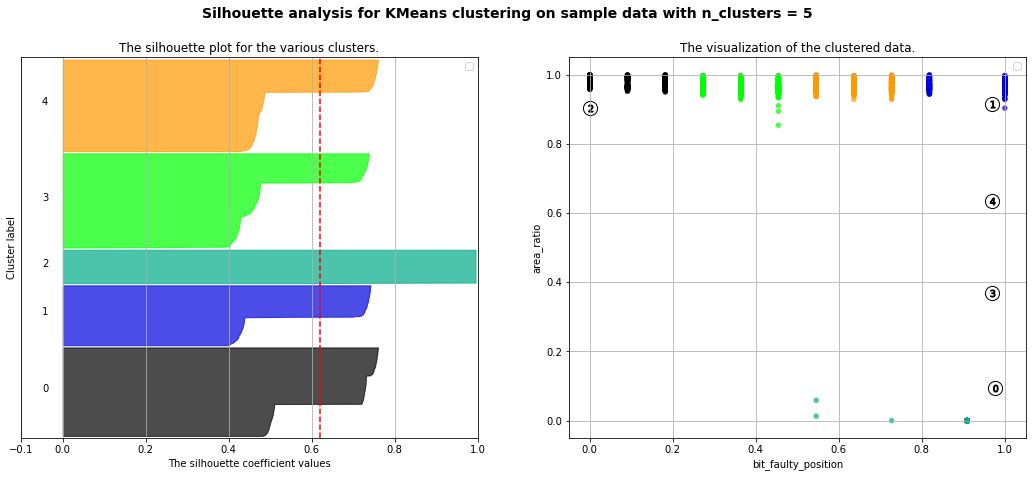

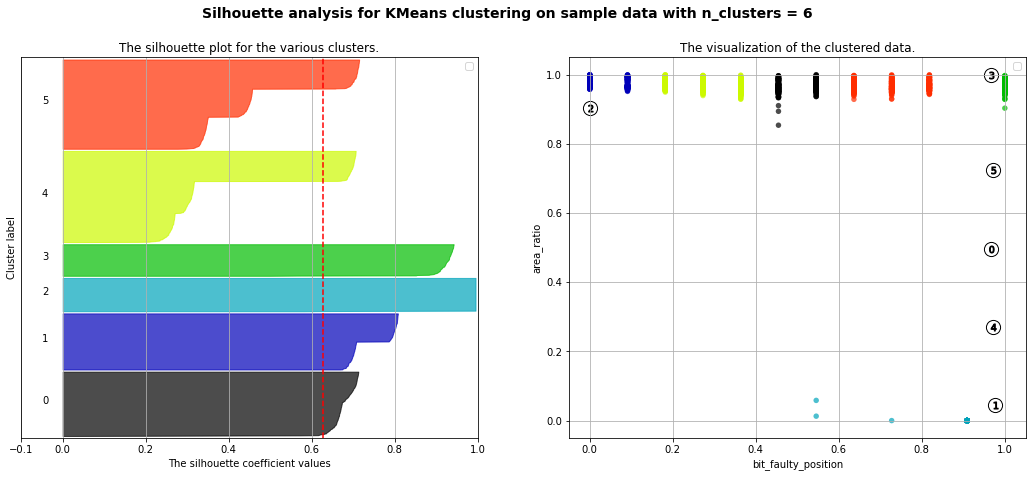

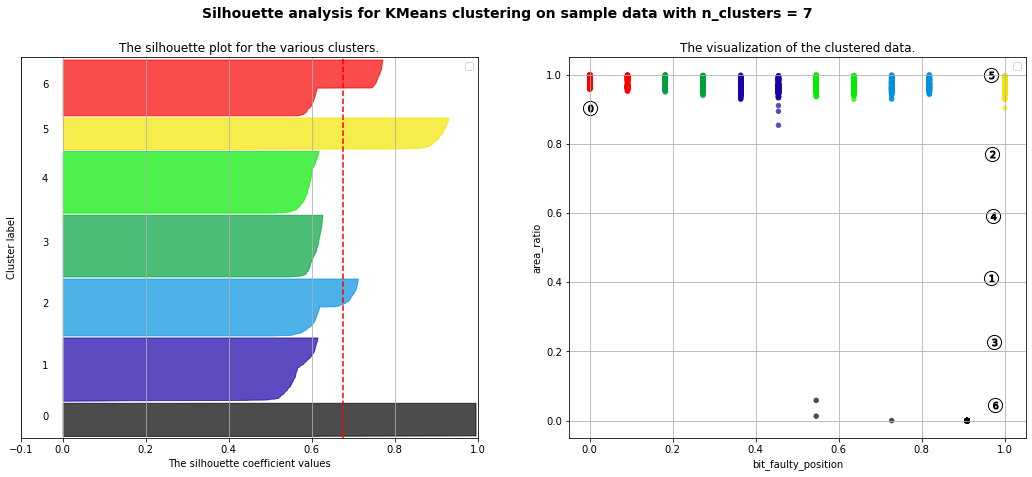

In [112]:
for n_clusters in range(2,8):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(scaled_clustering_df[['area_ratio', 'bit_faulty_position']]) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    # y_predicted = clusterer.fit_predict(scaled_clustering_df[['area_ratio', 'bit_faulty_position']])
    y_predicted = clusterer.fit_predict(scaled_clustering_df.iloc[:,1:])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # silhouette_avg = silhouette_score(scaled_clustering_df[['area_ratio', 'bit_faulty_position']], y_predicted)
    silhouette_avg = silhouette_score(scaled_clustering_df.iloc[:,1:], y_predicted)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    # Compute the silhouette scores for each sample
    # sample_silhouette_values = silhouette_samples(scaled_clustering_df[['area_ratio', 'bit_faulty_position']], y_predicted)
    sample_silhouette_values = silhouette_samples(scaled_clustering_df.iloc[:,1:], y_predicted)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[y_predicted == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
         # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(y_predicted.astype(float) / n_clusters)
    ax2.scatter(
        scaled_clustering_df['bit_faulty_position'], scaled_clustering_df['fault_iou@1'], marker="o", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("bit_faulty_position")
    ax2.set_ylabel("area_ratio")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
    ax1.grid()
    ax1.legend()
    ax2.grid()
    ax2.legend()
    # ax2.set_yscale('log')

plt.show()